In [1]:
%matplotlib inline


## Single estimator versus bagging



In [12]:
from scipy.interpolate import interp1d
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import glob
import random

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000      # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)


これどういう構造のデータなのかいまいちよくわからない
washbasinで使用した水のデータってこと？てなるとdisintegrationになってなくない？




In [3]:
# バイアス-バリアンス分解を実施したいモデルの設定

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

In [4]:
# データの設定
'''
これどういう構造のデータなのかいまいちよくわからない
washbasinで使用した水のデータってこと？てなるとdisintegrationになってなくない？

'''


n_estimators = len(estimators)
ts_files = glob.glob("data/csv_Washbasin/cluster_0/*.csv")
f_true = "data/csv_Washbasin/0_spline.csv"

print(ts_files)
print(f_true)

ts_files_viz = pd.read_csv(ts_files[0])
display(ts_files_viz)

f_true_viz = pd.read_csv(f_true)
display(f_true_viz)

['data/csv_Washbasin/cluster_0/97.csv', 'data/csv_Washbasin/cluster_0/83.csv', 'data/csv_Washbasin/cluster_0/68.csv', 'data/csv_Washbasin/cluster_0/54.csv', 'data/csv_Washbasin/cluster_0/69.csv', 'data/csv_Washbasin/cluster_0/96.csv', 'data/csv_Washbasin/cluster_0/43.csv', 'data/csv_Washbasin/cluster_0/57.csv', 'data/csv_Washbasin/cluster_0/42.csv', 'data/csv_Washbasin/cluster_0/81.csv', 'data/csv_Washbasin/cluster_0/46.csv', 'data/csv_Washbasin/cluster_0/52.csv', 'data/csv_Washbasin/cluster_0/53.csv', 'data/csv_Washbasin/cluster_0/86.csv', 'data/csv_Washbasin/cluster_0/51.csv', 'data/csv_Washbasin/cluster_0/3.csv', 'data/csv_Washbasin/cluster_0/50.csv', 'data/csv_Washbasin/cluster_0/37.csv', 'data/csv_Washbasin/cluster_0/20.csv', 'data/csv_Washbasin/cluster_0/108.csv', 'data/csv_Washbasin/cluster_0/24.csv', 'data/csv_Washbasin/cluster_0/27.csv', 'data/csv_Washbasin/cluster_0/33.csv', 'data/csv_Washbasin/cluster_0/117.csv', 'data/csv_Washbasin/cluster_0/103.csv', 'data/csv_Washbasin/cl

,1551444362 31
0,1551444363 40
1,1551444364 38
2,1551444365 36
3,1551444366 36
4,1551444367 38
5,1551444368 36
6,1551444369 38
7,1551444371 36
8,1551444372 36
9,1551444373 36


,0.0,40.0
0,2.000000,47.773898
1,4.000000,58.418914
2,6.000000,71.209457
3,8.000000,43.110876
4,10.000000,45.242650
5,12.000000,58.372309
6,14.141712,43.003912
7,16.008335,35.648151
8,19.000000,59.837318
9,22.001555,59.929654


In [5]:
ts_files_viz.dtypes

1551444362 31    object
dtype: object

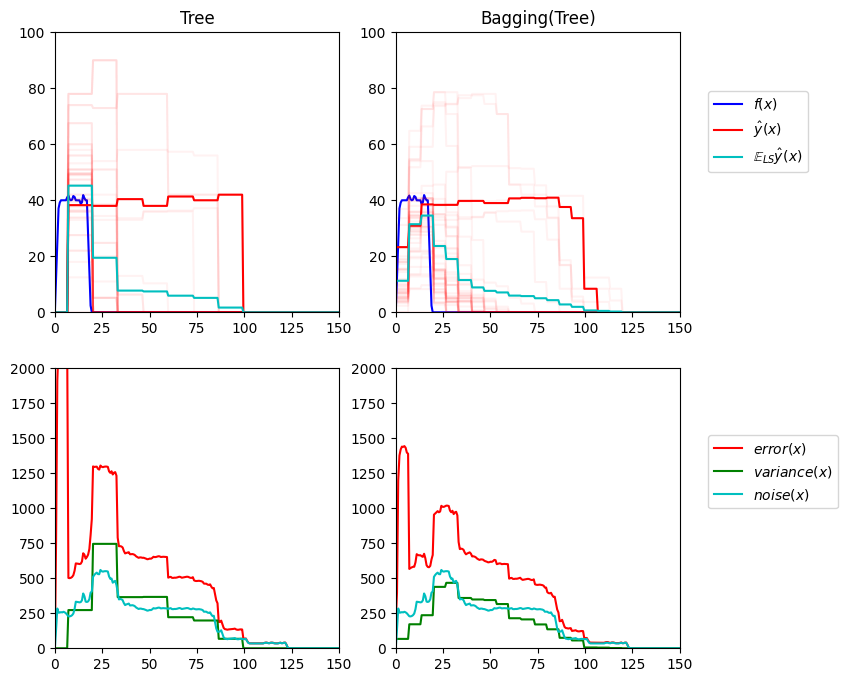

In [6]:
# ランダム関数のseedを固定
np.random.seed(1)

# 指定したデータの標準化と欠損値補完を実施する関数

def f(x, iteration):

    '''
    この部分で、指定されたCSVファイルから時系列データを読み込みます。iteration == -1 の場合は、ts_files[4] という特定のファイルを使い、それ以外のときは iteration の値に基づいて異なるデータファイルを選択します。
	読み込まれたデータは ts として格納されます。この ts は2次元配列で、1列目が時間（秒単位）、2列目が水の流量を表しています。
    '''
    if iteration==-1:
        ts = np.genfromtxt(ts_files[4], delimiter=" ")
    else:
        ts = np.genfromtxt(ts_files[iteration], delimiter=" ")

    '''
    読み込んだデータの最初の時刻（start_time）を基準にして、全ての時刻を0から始まるように正規化しています。
    これにより、時系列データの時間が全て相対的な値（経過時間）に変換されます。また、最初のデータポイントの流量（ts[0,1]）を0に設定しています。
    '''
    start_time = ts[0,0]
    ts[:,0] -= start_time
    ts[0,1] = 0

    '''
    時系列データの最後の時刻が650秒未満の場合、650秒まで延長します。
    具体的には、最後のデータポイントの1秒後と650秒の時刻における流量を0に設定して追加しています。これにより、補間の範囲を広げて、650秒までのデータが補間できるようにします。
    '''
    if ts[-1,0] < 650:
        ts = np.vstack((ts,[ts[-1,0]+1, 0]))
        ts = np.vstack((ts,[650, 0]))

    '''
    データの中間に流量が0の箇所があり、かつその次のデータポイントで流量が0でない場合、前後の流量の平均を使って補間します。
    これにより、急激な変化が発生しないように時系列データをスムーズにします。
    '''
    for i in range(1,len(ts)-1):
        if ts[i,1]==0 and ts[i+1,1]!=0:
            ts[i,1]=(ts[i-1,1]+ts[i+1,1])*0.5
    
    '''
    interp1d 関数を用いて、時系列データの時間と流量に基づく線形補間関数を作成します。この補間関数は、任意の時刻 x に対して対応する流量を返します。
	関数の戻り値として、この補間関数を x に適用して、補間された値が返されます。
    '''
    linfunc = interp1d(ts[:,0], ts[:,1])
    return linfunc(x)


# 指定されたサンプル数に基づいて訓練データやテストデータを生成するコード。
# じゃあ読み込んでるデータって何？
def generate(n_samples, n_repeat=1):
    '''
    np.linspace を使用して、0から650までの範囲で等間隔に n_samples 個のサンプルを生成し、
    X に格納します。X は、補間に使用される時間データです。
    '''
    X = np.linspace(0, 650, n_samples)

    '''
    n_repeat が 1 の場合、f 関数を使用して y の値を生成します。
    ts_files リストの中からランダムに 1 つのファイルを選んで使用します。
    np.random.randintで1~len(ts_files)までの数値をランダムに1つ取得。この数値を使ってts_filesのなかにある時系列データファイルをランダムに選択する。
    '''
    if n_repeat == 1:
        y = f(X, np.random.randint(1, len(ts_files)))
    else:
        '''
        n_repeat が 1 以外の場合、y を n_samples x n_repeat の形の配列として初期化し、
        複数回 (n_repeat 回) の補間を行います。各反復で異なるファイルをランダムに選んで y の列に格納します。
        '''
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X, np.random.randint(1, len(ts_files)))

    '''
    X の形を (n_samples, 1) に変形します。これにより、X は2次元の配列として出力され、
    回帰モデルに適した形式になります。
    '''
    X = X.reshape((n_samples, 1))

    '''
    X と y のペアを返します。X は時刻のサンプルであり、y はその時刻に対応する補間された流量データです。
    '''
    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test,  n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)


    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_var = np.var(y_predict, axis=1)




    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test,-1), "b", label="$f(x)$")
    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"$\mathbb{E}_{LS} \^y(x)$")

    # 350 → 150に変更
    plt.xlim([0, 150])
    plt.ylim([0, 100])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([0, 150])
    plt.ylim([0, 2000])
    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

	•	f(x): 実際の基準となる流量データ（観測値）。
	•	ŷ(x): モデルによる予測値。
	•	E[ŷ(x)]: 複数のモデル予測の平均（期待値）。
	•	error(x): モデル予測と実際のデータの誤差（MSE）。
	•	variance(x): モデル予測の分散（不安定さの指標）。
	•	noise(x): 実際のデータのノイズ（データの不確実性）。

	•	横軸（X）: 時間（秒）。時系列データにおける各時刻のサンプル。
	•	縦軸:
	•	上段グラフ: 水の流量（ml/sec）。
	•	下段グラフ: 誤差、分散、ノイズなどの統計的指標の値。

Text(0.5, 1.0, 'Bagging for decision trees, MSE = 111.99')

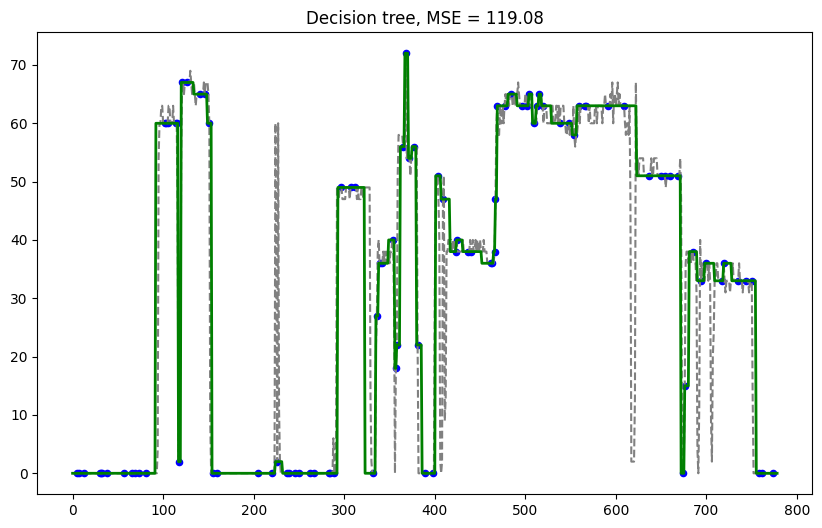

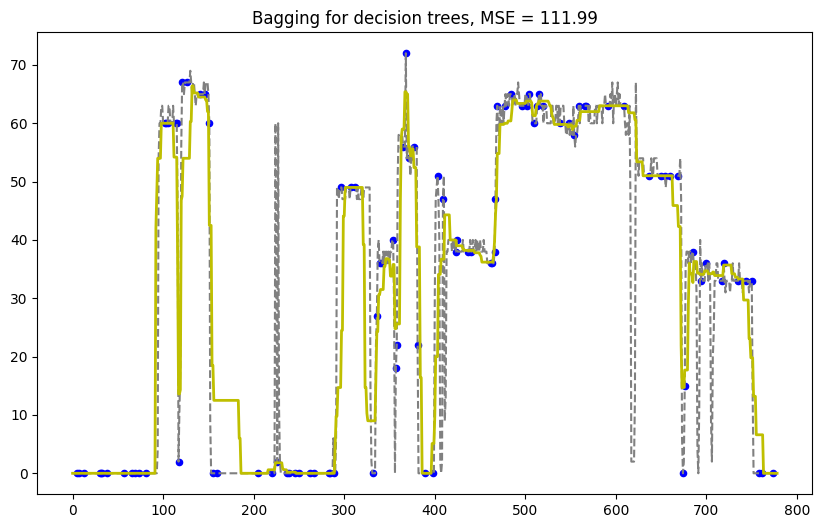

In [17]:
# oneday_kitchen予測モデル(モスさん提供の論文より)

n_train = 100
n_test = 779
#Generate data
def generate(n_samples):
    ts = np.genfromtxt('data/oneday_kitchen.csv', delimiter = ' ')
    start_time = ts[0,0]
    ts[:,0] -= start_time
    X = random.sample(range(0, len(ts)), n_samples)
    X.sort()
    y = ts[X,1]
    X = np.reshape(X, (n_samples, 1))
    return X, y

X_train, y_train = generate(n_samples = n_train)
X_test, y_test = generate(n_samples = n_test)

# One decision tree regressor
dtree = DecisionTreeRegressor().fit(X_train, y_train)
d_predict = dtree.predict(X_test)
plt.figure(figsize = (10, 6))
plt.plot(X_test, y_test, color = '0.5',linestyle = 'dashed')
plt.scatter(X_train, y_train, c = 'b', s = 20)
plt.plot(X_test, d_predict, 'g', lw = 2)
plt.title('Decision tree, MSE = %.2f'  % np.divide(np.sum((y_test - d_predict) ** 2),n_test))

# Bagging with a decision tree regressor
bdt = BaggingRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
bdt_predict = bdt.predict(X_test)
plt.figure(figsize = (10, 6))
plt.plot(X_test, y_test, color = '0.5',linestyle = 'dashed')
plt.scatter(X_train, y_train, c = 'b', s = 20)
plt.plot(X_test, bdt_predict, 'y', lw = 2)
plt.title('Bagging for decision trees, MSE = %.2f' % np.divide(np.sum((y_test - bdt_predict) ** 2),n_test))